In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from tqdm import trange

In [2]:
mnist = datasets.MNIST(root='./data', train=True, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5],std=[.5])
]))

In [3]:
batch_size = 64
data_loader = DataLoader(dataset = mnist, batch_size=batch_size, shuffle=True)

In [12]:
class Discriminator(nn.Module):
    def __init__(self,inp=1, out=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(inp, 512, 3, stride=2, padding=1, bias = True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(.2),
            
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias = True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(.2),
            
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias = True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(.2),
            nn.AvgPool2d(4),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128,1),
            nn.Sigmoid(),
        )
        
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [13]:
class Generator(nn.Module):
    def __init__(self, inp=100, out=28*28):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(inp, 4*4*512),
            nn.ReLU()
        )
    
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 1, 4 ,stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
            
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_)
        return y_

In [14]:
D = Discriminator().to('cuda')
G = Generator().to('cuda')

In [15]:
loss_function = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [16]:
max_epoch = 20
n_critic = 1
n_noise = 100

In [17]:
D_labels = torch.ones([batch_size,1]).to('cuda')
D_fakes = torch.zeros([batch_size,1]).to('cuda')
D_losses = []
G_losses = []
img_list = []

In [18]:
for epoch in (why := trange(max_epoch)):
    for step,(images, _) in enumerate(data_loader):
        x = images.to('cuda')
        x_output = D(x)
        D_x_loss = loss_function(x_output, D_labels)
        
        z = torch.randn(batch_size, n_noise).to('cuda')
        z_output = D(G(z))
        D_z_loss = loss_function(z_output, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        z = torch.randn(batch_size, n_noise).to('cuda')
        z_output = D(G(z))
        G_loss = loss_function(z_output, D_labels)
        
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        why.set_description('Step: {}, D Loss: {}, G Loss: {}'.format(step, D_loss.item(), G_loss.item()))
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())
        
        if step % 100 == 0:
            with torch.no_grad():
                fake = G(z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [512, 784, 3, 3], expected input[64, 1, 28, 28] to have 784 channels, but got 1 channels instead

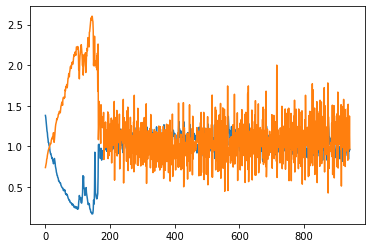

In [53]:
plt.plot(D_losses)
plt.plot(G_losses)

IndexError: list index out of range

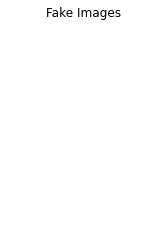

In [19]:
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

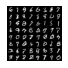

In [83]:
fig = plt.figure(figsize=(1,1))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[100:]]
ani = animation.ArtistAnimation(fig,ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [77]:
import matplotlib.animation as animation
from IPython.display import HTML

In [11]:
for step,(images, _) in enumerate(data_loader):
        x = images.to('cuda')
        print(x.size())
        break

torch.Size([64, 1, 28, 28])
